### Generate cluster with unsupervised learning
#### 1. Import data from descriptor_data.csv
#### 2. Generate PCA map


In [1]:
#Import all packages and set plots to be embedded inline
import numpy as np
import sklearn.gaussian_process as gp
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut, cross_val_score
import plotly.express as px
from sklearn.decomposition import PCA


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, mutual_info_score, adjusted_rand_score





In [2]:
X = pd.read_csv('descriptor_data.csv') 

In [3]:
X

Name  Metal  Atom_A  Atom_B  A-M-B Angle  M-A Distance  \
0      ligand-001-n-n-1      2      23      22     80.01004         2.324   
1      ligand-002-p-p-1      2      16      17     81.08750         2.404   
2      ligand-003-p-p-2      3       1      12     88.85482         2.393   
3      ligand-004-p-p-3      3      45       1     95.97953         2.432   
4      ligand-005-c-n-1      1       2      59     86.57124         2.143   
..                  ...    ...     ...     ...          ...           ...   
435  ligand-467-p-o-164     65       1       2     79.05611         2.410   
436  ligand-468-p-o-165     29       1      31     79.28552         2.409   
437  ligand-471-p-o-168     10       1      11     78.50039         2.405   
438  ligand-472-p-o-169     26       1      28     79.09274         2.409   
439  ligand-473-p-o-170     16       1       5     88.65991         2.404   

     M-B Distance  Metal_NBO    A_NBO    B_NBO  ...  % VBur asymm 2  \
0           2.324    0.26015 -0.42686 -0.42686  ...        0.067555   
1           2.406   -0.11874  1.06691  1.06830  ...        5.049152   
2           2.398   -0.12498  1.08763  1.08260  ...        0.099003   
3           2.441   -0.09320  1.06382  1.05890  ...        0.822307   
4           2.295    0.17756  0.22924 -0.40636  ...       15.149786   
..            ...        ...      ...      ...  ...             ...   
435         2.347    0.17601  1.23805 -1.05913  ...       17.178764   
436         2.236    0.18785  1.01981 -0.67258  ...       11.816297   
437         2.209    0.15421  1.03570 -0.69794  ...       13.316483   
438         2.245    0.18785  1.02488 -0.66367  ...       11.889676   
439         2.260    0.16067  1.04322 -0.94989  ...       14.753774   

     % VBur asymm 3  % VBur octant 1  % VBur octant 2  % VBur octant 3  \
0          0.051249        79.276929        75.605665        79.304883   
1          3.262439        81.564480        92.051808        83.060007   
2          0.173546        74.021618        74.375699        95.387626   
3          1.202013        97.623928        96.230898        70.308423   
4         30.368291        64.340291        88.292024        40.775252   
..              ...              ...              ...              ...   
435        0.646431        96.449870        85.645732        50.703504   
436        0.644102        90.933656        86.423779        66.539322   
437        2.120993        72.768356        54.267611        58.674991   
438        1.288204        91.231830        86.591502        63.385203   
439        3.076081        79.472605        56.699590        66.781588   

     % VBur octant 4  % VBur octant 5  % VBur octant 6  % VBur octant 7  \
0          75.750093         4.034663         0.242266         3.866940   
1          82.575475         5.101565         8.190458         6.671636   
2          96.706113         8.866008        10.035408        10.860045   
3          71.878494        11.675363        12.486023        18.496086   
4          96.850540        44.781960         9.821096        17.815878   
..               ...              ...              ...              ...   
435        80.609392         5.744502         0.000000         4.449310   
436        84.411107         7.538204         0.489191        15.234812   
437        84.984160         5.278606         0.712821         0.573053   
438        83.469996         6.708908         0.437943        16.432165   
439        85.748230         5.040999         0.652255         0.838613   

     % VBur octant 8  
0           0.228289  
1           0.535781  
2          10.669027  
3          13.054417  
4          11.330600  
..               ...  
435        26.709840  
436        33.069325  
437         4.463287  
438        32.994782  
439        13.725307  

[440 rows x 87 columns]

In [4]:
# Create a boolean mask where any column contains the string 'NaN'
mask = X.apply(lambda x: x.astype(str).str.contains('NaN', na=False)).any(axis=1)

# Get the indices of the rows where the mask is True
nan_indices = X[mask].index
missing_values = X.isnull()

# Get the indices of rows with missing values
rows_with_missing = X[X.isnull().any(axis=1)]

# Print the rows with missing values
print("\nRows with missing values:")
print(rows_with_missing)

# Get the indices of rows with missing values
missing_indices = rows_with_missing.index.tolist()

# Remove that indices by dropping
X = X.dropna()

# Add two columns, one with ligand_id, one with donor_atom_combination
# Extract the 3-digit ligand ID and the donor atom combination
X['ligand_id'] = X['Name'].str.extract(r'ligand-(\d{3})')
X['donor_atom_comb'] = X['Name'].str.extract(r'ligand-\d{3}-([a-z]-[a-z])')


Rows with missing values:
               Name  Metal  Atom_A  Atom_B  A-M-B Angle  M-A Distance  \
0  ligand-001-n-n-1      2      23      22     80.01004         2.324   

   M-B Distance  Metal_NBO    A_NBO    B_NBO  ...  % VBur asymm 2  \
0         2.324    0.26015 -0.42686 -0.42686  ...        0.067555   

   % VBur asymm 3  % VBur octant 1  % VBur octant 2  % VBur octant 3  \
0        0.051249        79.276929        75.605665        79.304883   

   % VBur octant 4  % VBur octant 5  % VBur octant 6  % VBur octant 7  \
0        75.750093         4.034663         0.242266          3.86694   

   % VBur octant 8  
0         0.228289  

[1 rows x 87 columns]


C:\Users\George\AppData\Local\Temp\ipykernel_79616\2624253388.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ligand_id'] = X['Name'].str.extract(r'ligand-(\d{3})')
C:\Users\George\AppData\Local\Temp\ipykernel_79616\2624253388.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['donor_atom_comb'] = X['Name'].str.extract(r'ligand-\d{3}-([a-z]-[a-z])')


In [5]:
X

Name  Metal  Atom_A  Atom_B  A-M-B Angle  M-A Distance  \
1      ligand-002-p-p-1      2      16      17     81.08750         2.404   
2      ligand-003-p-p-2      3       1      12     88.85482         2.393   
3      ligand-004-p-p-3      3      45       1     95.97953         2.432   
4      ligand-005-c-n-1      1       2      59     86.57124         2.143   
5      ligand-006-c-n-2      1       2      44     86.23337         2.145   
..                  ...    ...     ...     ...          ...           ...   
435  ligand-467-p-o-164     65       1       2     79.05611         2.410   
436  ligand-468-p-o-165     29       1      31     79.28552         2.409   
437  ligand-471-p-o-168     10       1      11     78.50039         2.405   
438  ligand-472-p-o-169     26       1      28     79.09274         2.409   
439  ligand-473-p-o-170     16       1       5     88.65991         2.404   

     M-B Distance  Metal_NBO    A_NBO    B_NBO  ...  % VBur octant 1  \
1           2.406   -0.11874  1.06691  1.06830  ...        81.564480   
2           2.398   -0.12498  1.08763  1.08260  ...        74.021618   
3           2.441   -0.09320  1.06382  1.05890  ...        97.623928   
4           2.295    0.17756  0.22924 -0.40636  ...        64.340291   
5           2.253    0.17159  0.23504 -0.40535  ...        68.766306   
..            ...        ...      ...      ...  ...              ...   
435         2.347    0.17601  1.23805 -1.05913  ...        96.449870   
436         2.236    0.18785  1.01981 -0.67258  ...        90.933656   
437         2.209    0.15421  1.03570 -0.69794  ...        72.768356   
438         2.245    0.18785  1.02488 -0.66367  ...        91.231830   
439         2.260    0.16067  1.04322 -0.94989  ...        79.472605   

     % VBur octant 2  % VBur octant 3  % VBur octant 4  % VBur octant 5  \
1          92.051808        83.060007        82.575475         5.101565   
2          74.375699        95.387626        96.706113         8.866008   
3          96.230898        70.308423        71.878494        11.675363   
4          88.292024        40.775252        96.850540        44.781960   
5          82.636042        51.118151        87.183190        25.987700   
..               ...              ...              ...              ...   
435        85.645732        50.703504        80.609392         5.744502   
436        86.423779        66.539322        84.411107         7.538204   
437        54.267611        58.674991        84.984160         5.278606   
438        86.591502        63.385203        83.469996         6.708908   
439        56.699590        66.781588        85.748230         5.040999   

     % VBur octant 6  % VBur octant 7  % VBur octant 8  ligand_id  \
1           8.190458         6.671636         0.535781        002   
2          10.035408        10.860045        10.669027        003   
3          12.486023        18.496086        13.054417        004   
4           9.821096        17.815878        11.330600        005   
5           0.475214        14.018822         9.122251        006   
..               ...              ...              ...        ...   
435         0.000000         4.449310        26.709840        467   
436         0.489191        15.234812        33.069325        468   
437         0.712821         0.573053         4.463287        471   
438         0.437943        16.432165        32.994782        472   
439         0.652255         0.838613        13.725307        473   

     donor_atom_comb  
1                p-p  
2                p-p  
3                p-p  
4                c-n  
5                c-n  
..               ...  
435              p-o  
436              p-o  
437              p-o  
438              p-o  
439              p-o  

[439 rows x 89 columns]

In [6]:
X.columns

Index(['Name', 'Metal', 'Atom_A', 'Atom_B', 'A-M-B Angle', 'M-A Distance',
       'M-B Distance', 'Metal_NBO', 'A_NBO', 'B_NBO', 'HOMO_LUMO', 'A-B_NBO',
       'NBO-dist-2-avg', 'NBO-dist-3-avg', 'NBO-dist-4-avg',
       'NBO-dist-2-a-avg', 'NBO-dist-3-a-avg', 'NBO-dist-4-a-avg',
       'NBO-dist-2-b-avg', 'NBO-dist-3-b-avg', 'NBO-dist-4-b-avg',
       'NBO-dist-2-a-b-diff', 'NBO-dist-3-a-b-diff', 'NBO-dist-4-a-b-diff',
       'NBO-dist-2-min', 'NBO-dist-3-min', 'NBO-dist-4-min', 'NBO-dist-2-max',
       'NBO-dist-3-max', 'NBO-dist-4-max', 'NBO-dist-2-a-min',
       'NBO-dist-3-a-min', 'NBO-dist-4-a-min', 'NBO-dist-2-b-min',
       'NBO-dist-3-b-min', 'NBO-dist-4-b-min', 'NBO-dist-2-a-max',
       'NBO-dist-3-a-max', 'NBO-dist-4-a-max', 'NBO-dist-2-b-max',
       'NBO-dist-3-b-max', 'NBO-dist-4-b-max', 'NBO-metal-donor-diff',
       'NBO-metal-a-diff', 'NBO-metal-b-diff', 'NBO-dist-2-1-avg-diff',
       'NBO-dist-3-2-avg-diff', 'NBO-dist-4-3-avg-diff',
       'NBO-dist-2-1-a-avg-diff',

In [7]:
print(type(X['A-B_NBO']))
A_B_NBO_values = X['A-B_NBO'].tolist()
float_values = [float(value) for value in A_B_NBO_values]
names = X['Name'].tolist()
ligand_id = X['ligand_id'].tolist()
donor_atom_comb = X['donor_atom_comb'].tolist()
X_2 = X.drop(['Name', 'Metal','Atom_A', 'Atom_B','ligand_id','donor_atom_comb'], axis=1)

<class 'pandas.core.series.Series'>


In [8]:
percent_buried_volume = X['Total % VBur']
percent_buried_volume = [float(value) for value in percent_buried_volume]

#### Generate PCA map with all descriptors (electronic and steric)
#### Color for data point represents each 'class' of ligand

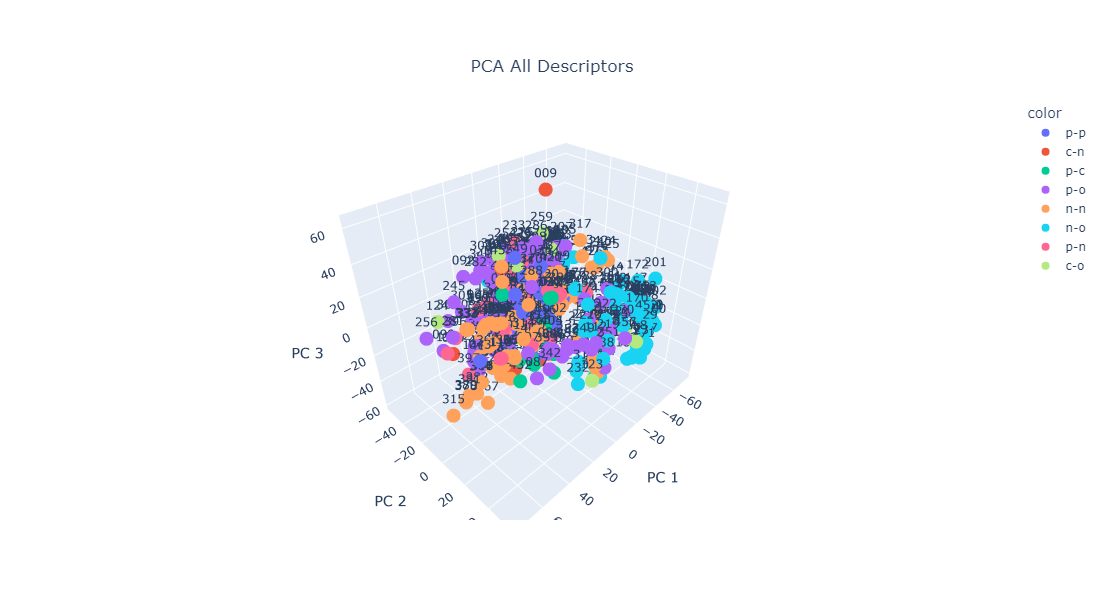

In [9]:
# Generate PCA map with ALL descriptors - find out cluster combinations through this

pca = PCA(n_components=3)
components = pca.fit_transform(X_2)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components,
    x=0,
    y=1,
    z=2,
    text=ligand_id,
    color = donor_atom_comb,
    title=f'PCA All Descriptors',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)

fig.update_layout(width=800, 
                  height=600,
                  coloraxis_colorbar=dict(
                  title=dict(text="Percent Buried<br>Volume",
                             side="top"),
                  x=0.85,  # Position the legend closer to the scatter plot
                  y=0.5,
                  xanchor='left',
                  yanchor='middle'),
                  title=dict(
                  x=0.5,          # Horizontal position (centered)
                  y=0.9,          # Vertical position (closer to the plot)
                  xanchor='center',
                  yanchor='top'
                    ) 
                 )
fig.show()

# Save the figure as PNG
fig.write_image("pca_3d_plot_all.png")

# Save the figure as HTML
fig.write_html("pca_3d_plot_all.html")

C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with M

 - Best Silhouette score: 0.3570108170137557, No. of clusters: 5
 - Best Davies-Bouldin score: 0.9179528103600132, No. of clusters: 27
 - Best Calinski-Harabasz score: 274.6664314665077, No. of clusters: 3


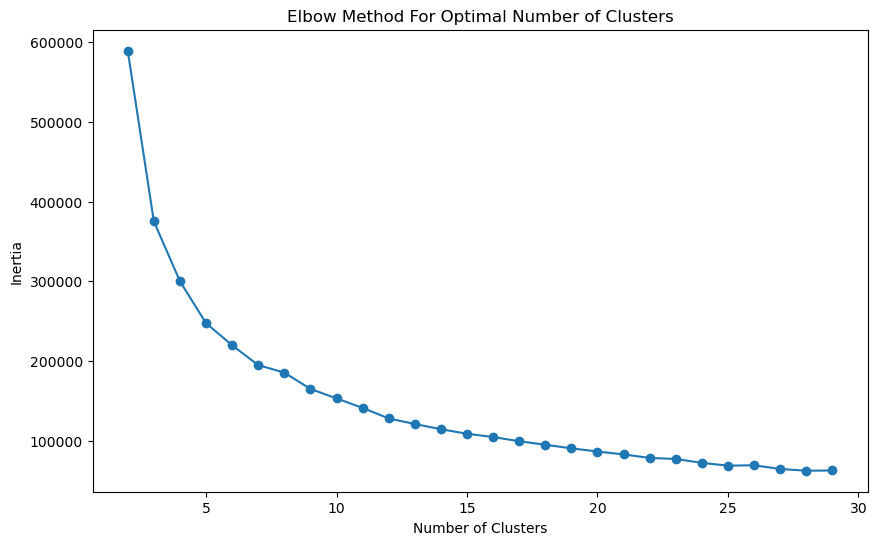

C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.




PCA Result DataFrame with Cluster Labels:
           PC1        PC2        PC3  Cluster Ligand
0    -1.877759   7.119581  -6.371626        3    NaN
1    10.267508   4.253167   5.759521        3    002
2    17.035173  -2.612191  -5.006768        2    003
3     9.722353 -28.677892 -57.280909        0    004
4   -10.873945 -25.223107 -38.418465        0    005
..         ...        ...        ...      ...    ...
434  -4.770942 -40.074653  -6.997821        0    466
435  13.563965 -25.661686  -4.192291        0    467
436 -43.526883 -32.517062  -2.021665        4    468
437  11.563072 -27.165826  -6.242479        0    471
438 -29.017301 -31.777727   8.872974        4    472

[439 rows x 5 columns]


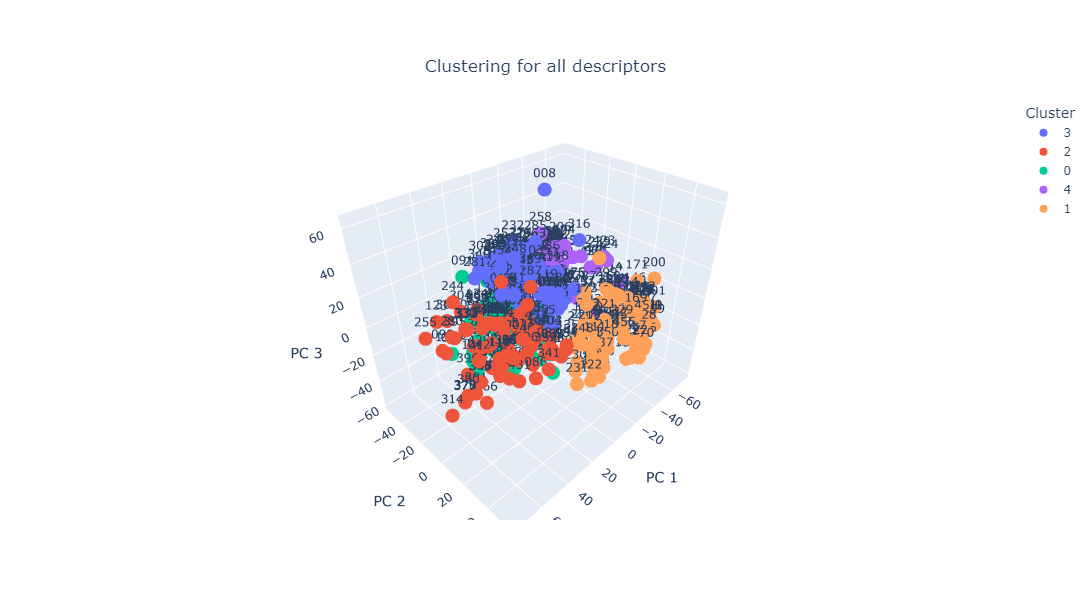

{'c1': ['004', '005', '006', '007', '009', '013', '014', '015', '016', '027', '029', '033', '048', '053', '080', '081', '082', '091', '093', '095', '097', '100', '107', '120', '124', '131', '135', '137', '138', '139', '140', '142', '143', '144', '189', '192', '195', '233', '234', '242', '243', '245', '246', '249', '260', '261', '262', '267', '268', '271', '273', '277', '278', '286', '289', '290', '291', '292', '293', '324', '328', '368', '370', '390', '398', '406', '407', '408', '410', '422', '430', '441', '442', '444', '445', '446', '447', '448', '449', '461', '466', '467', '471'], 'c2': ['038', '072', '073', '074', '075', '076', '077', '078', '092', '099', '111', '121', '122', '145', '146', '149', '150', '151', '160', '161', '168', '169', '170', '171', '172', '173', '174', '177', '178', '179', '180', '181', '182', '183', '186', '199', '200', '201', '202', '205', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '223', '224

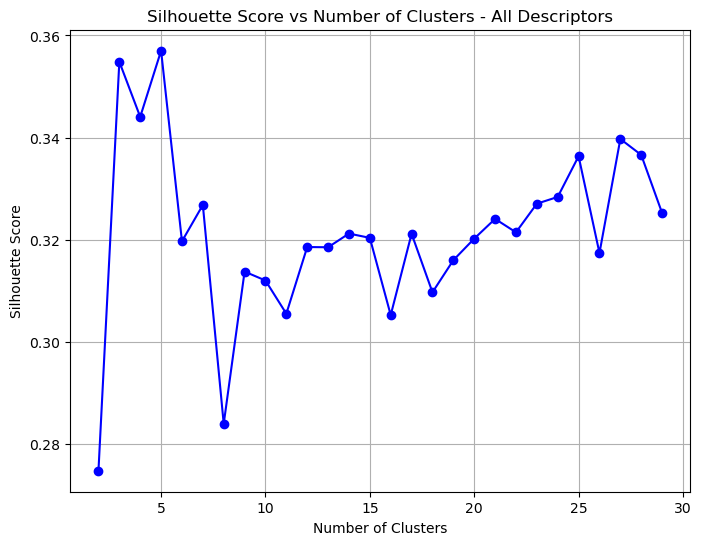

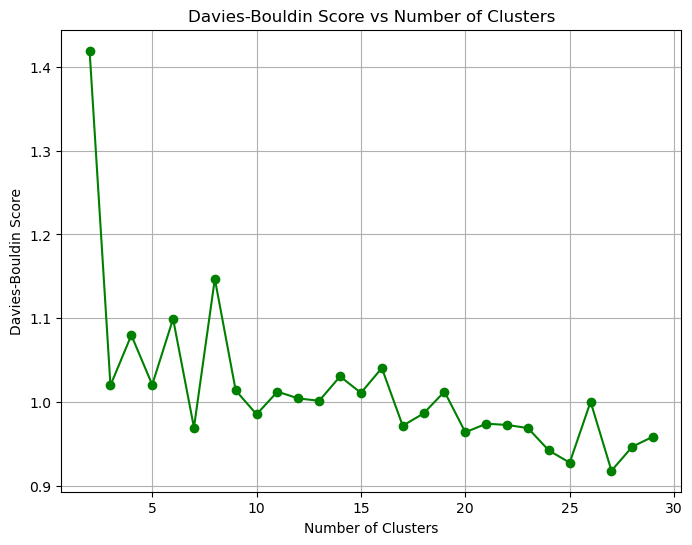

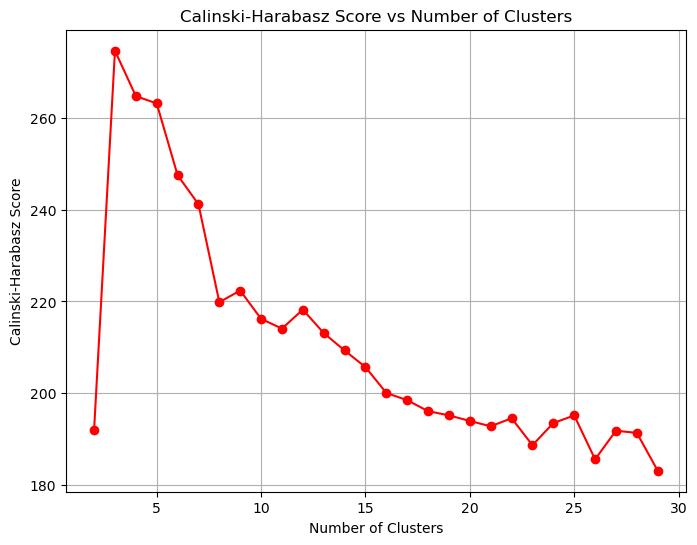

In [10]:
# Generate dataframe from pca data: 
pca_df = pd.DataFrame(data=components, columns=['PC1', 'PC2','PC3'])

# Apply KMeans Clustering
# Define a range of clusters to evaluate
range_n_clusters = list(range(2, 30))

# Initialize variables to store the best number of clusters and corresponding metrics
best_n_clusters_davies_bouldin = 0
best_n_clusters_silhouette = 0
best_n_clusters_calinski_harabasz = 0
best_silhouette_score = -1
best_davies_bouldin_score = float('inf')
best_calinski_harabasz_score = -1
best_adjusted_rand_score = -1
best_mutual_info_score = -1
inertia = []

# Initialize lists to store the metrics for each number of clusters
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

# Iterate over different cluster numbers to find the optimal number
for n_clusters in range_n_clusters:
    kmeans= KMeans(init="k-means++", n_clusters=n_clusters, n_init=4, random_state=42)
    cluster_labels = kmeans.fit_predict(pca_df)
    
    # Calculate clustering metcis
    silhouette_avg = silhouette_score(pca_df, cluster_labels)
    db_score = davies_bouldin_score(pca_df, cluster_labels)
    ch_score = calinski_harabasz_score(pca_df, cluster_labels)
    inertia.append(kmeans.inertia_)
    
    # Append metrics to corresponding lists
    silhouette_scores.append(silhouette_avg)
    davies_bouldin_scores.append(db_score)
    calinski_harabasz_scores.append(ch_score)
    
    # Print the scores for the current number of clusters
    # print(f"For n_clusters = {n_clusters}:")
    # print(f" - Silhouette score: {silhouette_avg}")
    # print(f" - Davies-Bouldin score: {db_score}")
    # print(f" - Calinski-Harabasz score: {ch_score}")
    
    # Update the best silhouette score and corresponding number of clusters
    if silhouette_avg > best_silhouette_score:
        best_n_clusters_silhouette = n_clusters
        best_silhouette_score = silhouette_avg

    if db_score < best_davies_bouldin_score:               # Lower Davies-Bouldin score == better
        best_n_clusters_davies_bouldin = n_clusters
        best_davies_bouldin_score = db_score

    if ch_score > best_calinski_harabasz_score:
        best_n_clusters_calinski_harabasz = n_clusters
        best_calinski_harabasz_score = ch_score

# Print the optimal number of clusters and the best silhouette score
print(f" - Best Silhouette score: {best_silhouette_score}, No. of clusters: {best_n_clusters_silhouette}")
print(f" - Best Davies-Bouldin score: {best_davies_bouldin_score}, No. of clusters: {best_n_clusters_davies_bouldin}")
print(f" - Best Calinski-Harabasz score: {best_calinski_harabasz_score}, No. of clusters: {best_n_clusters_calinski_harabasz}")

# Plot the inertia to visualize the elbow method
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Apply KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=best_n_clusters_silhouette, random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)

# Add cluster labels to the PCA result DataFrame
pca_df['Cluster'] = cluster_labels
pca_df['Ligand'] = X['ligand_id']


# Print the PCA result DataFrame with cluster labels
print("\nPCA Result DataFrame with Cluster Labels:")
print(pca_df)


# Create a dictionary to store clusters and their corresponding ligands
cluster_dict_all_descriptor = {}
for cluster_num in range(best_n_clusters_silhouette):                                             
    cluster_key = f'c{cluster_num + 1}'  # Create cluster key like 'c1', 'c2', etc.
    ligands_in_cluster = pca_df[pca_df['Cluster'] == cluster_num]['Ligand'].tolist()
    cluster_dict_all_descriptor[cluster_key] = ligands_in_cluster

# Visualize PCA with the best number of clusters
# Perform PCA to reduce to 3 dimensions for visualization
pca = PCA(n_components=3)
components = pca.fit_transform(X_2)

# Calculate the total variance explained by the first 3 components
total_var = pca.explained_variance_ratio_.sum() * 100

# Create a 3D scatter plot using Plotly, coloring points by cluster labels
fig = px.scatter_3d(
    components,
    x=0,
    y=1,
    z=2,
    color=pca_df['Cluster'].astype(str),  # Convert cluster labels to string for color differentiation
    text=pca_df['Ligand'],
    title=f'Clustering for all descriptors',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3', 'color': 'Cluster'}
)

# Update layout for the 3D scatter plot
fig.update_layout(
    width=800, 
    height=600,
    coloraxis_colorbar=dict(
        title=dict(text="Cluster",
                   side="top"),
        x=0.85,  # Position the legend closer to the scatter plot
        y=0.5,
        xanchor='left',
        yanchor='middle'
    ),
    title=dict(
        x=0.5,          # Horizontal position (centered)
        y=0.9,          # Vertical position (closer to the plot)
        xanchor='center',
        yanchor='top'
    )
)

# Show the plot
fig.show()

# Save the figure as PNG
fig.write_image("pca_3d_plot_all_cluster.png")

# Save the figure as HTML
fig.write_html("pca_3d_plot_all_cluster.html")

# Print the dictionary
print(cluster_dict_all_descriptor)

# Plot Silhouette Score
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, silhouette_scores, label='Silhouette Score', marker='o', color='blue')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters - All Descriptors')
plt.grid(True)
# Save the figure
plt.savefig("silhouette_score_plot_all.png", format='png')
plt.show()

# Plot Davies-Bouldin Score
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, davies_bouldin_scores, label='Davies-Bouldin Score', marker='o', color='green')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Score vs Number of Clusters')
plt.grid(True)
plt.show()

# Plot Calinski-Harabasz Score
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, calinski_harabasz_scores, label='Calinski-Harabasz Score', marker='o', color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Score')
plt.title('Calinski-Harabasz Score vs Number of Clusters')
plt.grid(True)
plt.show()



In [11]:
#Obtain only nbo based descriptor X_nbo
# Obtain only percent buried volume based descriptor X_Vbur 

X_2_columns = X_2.columns
print(X_2_columns)

nbo_list = ['Metal_NBO', 'A_NBO', 'B_NBO', 'HOMO_LUMO', 'A-B_NBO',
       'NBO-dist-2-avg', 'NBO-dist-3-avg', 'NBO-dist-4-avg',
       'NBO-dist-2-a-avg', 'NBO-dist-3-a-avg', 'NBO-dist-4-a-avg',
       'NBO-dist-2-b-avg', 'NBO-dist-3-b-avg', 'NBO-dist-4-b-avg',
       'NBO-dist-2-a-b-diff', 'NBO-dist-3-a-b-diff', 'NBO-dist-4-a-b-diff',
       'NBO-dist-2-min', 'NBO-dist-3-min', 'NBO-dist-4-min', 'NBO-dist-2-max',
       'NBO-dist-3-max', 'NBO-dist-4-max', 'NBO-dist-2-a-min',
       'NBO-dist-3-a-min', 'NBO-dist-4-a-min', 'NBO-dist-2-b-min',
       'NBO-dist-3-b-min', 'NBO-dist-4-b-min', 'NBO-dist-2-a-max',
       'NBO-dist-3-a-max', 'NBO-dist-4-a-max', 'NBO-dist-2-b-max',
       'NBO-dist-3-b-max', 'NBO-dist-4-b-max', 'NBO-metal-donor-diff',
       'NBO-metal-a-diff', 'NBO-metal-b-diff', 'NBO-dist-2-1-avg-diff',
       'NBO-dist-3-2-avg-diff', 'NBO-dist-4-3-avg-diff',
       'NBO-dist-2-1-a-avg-diff', 'NBO-dist-3-2-a-avg-diff',
       'NBO-dist-4-3-a-avg-diff', 'NBO-dist-2-1-b-avg-diff',
       'NBO-dist-3-2-b-avg-diff', 'NBO-dist-4-3-b-avg-diff', 'Metal_mullkien',
       'A_mulliken', 'B_mulliken', 'A-B_mulliken', 'Mulliken-dist-2-avg',
       'Mulliken-dist-3-avg', 'Mulliken-dist-4-avg']


vbur_list = ['Total % VBur', '% VBur SE',
       '% VBur SW', '% VBur NE', '% VBur NW', '% VBur max', '% VBur min',
       '% VBur max min diff', '% VBur NE NW diff', '% VBur SE SW diff',
       '% VBur NE SE diff', '% VBur NW SW diff', '% VBur NE SW diff',
       '% VBur NW SE diff', '% VBur asymm 1', '% VBur asymm 2',
       '% VBur asymm 3', '% VBur octant 1', '% VBur octant 2',
       '% VBur octant 3', '% VBur octant 4', '% VBur octant 5',
       '% VBur octant 6', '% VBur octant 7', '% VBur octant 8']

X_nbo = X_2[nbo_list]
X_vbur = X_2[vbur_list]

Index(['A-M-B Angle', 'M-A Distance', 'M-B Distance', 'Metal_NBO', 'A_NBO',
       'B_NBO', 'HOMO_LUMO', 'A-B_NBO', 'NBO-dist-2-avg', 'NBO-dist-3-avg',
       'NBO-dist-4-avg', 'NBO-dist-2-a-avg', 'NBO-dist-3-a-avg',
       'NBO-dist-4-a-avg', 'NBO-dist-2-b-avg', 'NBO-dist-3-b-avg',
       'NBO-dist-4-b-avg', 'NBO-dist-2-a-b-diff', 'NBO-dist-3-a-b-diff',
       'NBO-dist-4-a-b-diff', 'NBO-dist-2-min', 'NBO-dist-3-min',
       'NBO-dist-4-min', 'NBO-dist-2-max', 'NBO-dist-3-max', 'NBO-dist-4-max',
       'NBO-dist-2-a-min', 'NBO-dist-3-a-min', 'NBO-dist-4-a-min',
       'NBO-dist-2-b-min', 'NBO-dist-3-b-min', 'NBO-dist-4-b-min',
       'NBO-dist-2-a-max', 'NBO-dist-3-a-max', 'NBO-dist-4-a-max',
       'NBO-dist-2-b-max', 'NBO-dist-3-b-max', 'NBO-dist-4-b-max',
       'NBO-metal-donor-diff', 'NBO-metal-a-diff', 'NBO-metal-b-diff',
       'NBO-dist-2-1-avg-diff', 'NBO-dist-3-2-avg-diff',
       'NBO-dist-4-3-avg-diff', 'NBO-dist-2-1-a-avg-diff',
       'NBO-dist-3-2-a-avg-diff', 'NBO-dist

In [12]:
X_vbur

Total % VBur  % VBur SE  % VBur SW  % VBur NE  % VBur NW  % VBur max  \
1       44.968901  41.050130  49.361722  43.838520  45.625233   49.361722   
2       47.615193  42.345322  42.617872  52.786060  52.711517   52.786060   
3       48.969204  55.339173  57.363492  41.776929  41.397223   57.363492   
4       46.750955  37.835445  53.053951  70.816250  25.298174   70.816250   
5       42.413460  38.944279  48.327432  56.585445  25.796683   56.585445   
..            ...        ...        ...        ...        ...         ...   
435     43.789019  61.579855  45.047521  43.176947  25.351752   61.579855   
436     48.079925  62.001491  50.829296  45.974655  33.514256   62.001491   
437     35.215361  38.615822  27.420332  45.131383  29.693906   45.131383   
438     47.656541  62.113306  51.511834  45.089452  31.911573   62.113306   
439     38.619898  46.598956  28.769102  45.394614  33.716921   46.598956   

     % VBur min  % VBur max min diff  % VBur NE NW diff  % VBur SE SW diff  \
1     41.050130             8.311592          44.731877          45.205926   
2     42.345322            10.440738          52.748789          42.481597   
3     41.397223            15.966269          41.587076          56.351332   
4     25.298174            45.518077          48.057212          45.444698   
5     25.796683            30.788763          41.191064          43.635855   
..          ...                  ...                ...                ...   
435   25.351752            36.228103          34.264350          53.313688   
436   33.514256            28.487234          39.744456          56.415393   
437   27.420332            17.711051          37.412644          33.018077   
438   31.911573            30.201733          38.500512          56.812570   
439   28.769102            17.829855          39.555768          37.684029   

     ...  % VBur asymm 2  % VBur asymm 3  % VBur octant 1  % VBur octant 2  \
1    ...        5.049152        3.262439        81.564480        92.051808   
2    ...        0.099003        0.173546        74.021618        74.375699   
3    ...        0.822307        1.202013        97.623928        96.230898   
4    ...       15.149786       30.368291        64.340291        88.292024   
5    ...       10.702805       20.085958        68.766306        82.636042   
..   ...             ...             ...              ...              ...   
435  ...       17.178764        0.646431        96.449870        85.645732   
436  ...       11.816297        0.644102        90.933656        86.423779   
437  ...       13.316483        2.120993        72.768356        54.267611   
438  ...       11.889676        1.288204        91.231830        86.591502   
439  ...       14.753774        3.076081        79.472605        56.699590   

     % VBur octant 3  % VBur octant 4  % VBur octant 5  % VBur octant 6  \
1          83.060007        82.575475         5.101565         8.190458   
2          95.387626        96.706113         8.866008        10.035408   
3          70.308423        71.878494        11.675363        12.486023   
4          40.775252        96.850540        44.781960         9.821096   
5          51.118151        87.183190        25.987700         0.475214   
..               ...              ...              ...              ...   
435        50.703504        80.609392         5.744502         0.000000   
436        66.539322        84.411107         7.538204         0.489191   
437        58.674991        84.984160         5.278606         0.712821   
438        63.385203        83.469996         6.708908         0.437943   
439        66.781588        85.748230         5.040999         0.652255   

     % VBur octant 7  % VBur octant 8  
1           6.671636         0.535781  
2          10.860045        10.669027  
3          18.496086        13.054417  
4          17.815878        11.330600  
5          14.018822         9.122251  
..               ...              ...  
435         4.449310     

### Generate PCA map with V_bur descriptors - find out cluster combinations through this

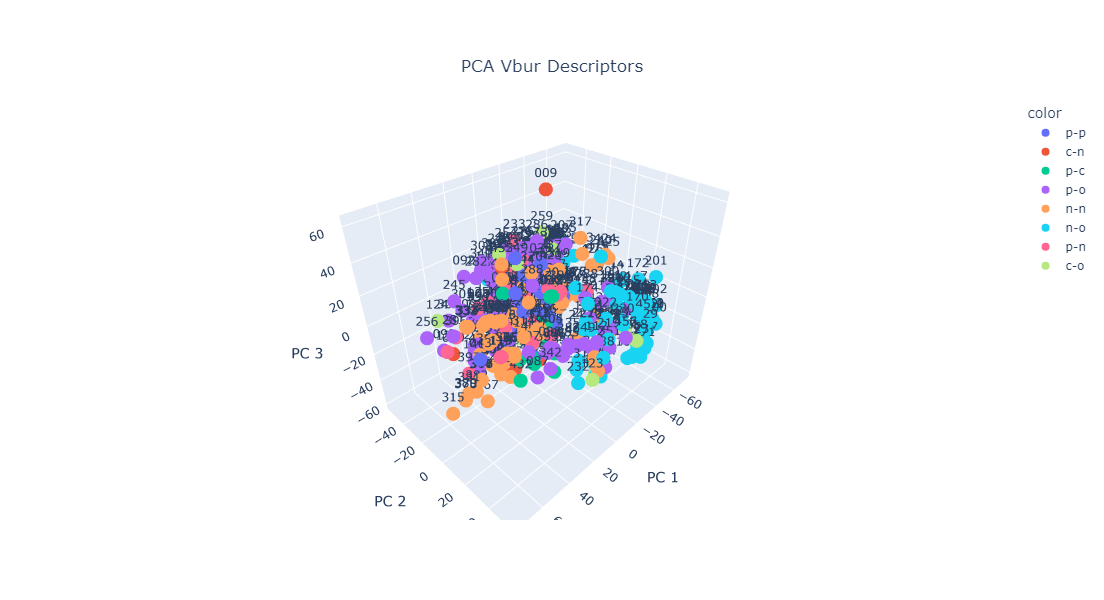

In [13]:
A_B_NBO_values = X_nbo['A-B_NBO'].tolist()
float_values = [float(value) for value in A_B_NBO_values]

A_NBO_values = X_nbo['A_NBO'].tolist()
float_values = [float(value) for value in A_NBO_values]

vbur_values = X_vbur['Total % VBur'].tolist()
vbur_values = [float(value) for value in vbur_values]

vbur_max_values = X_vbur['% VBur max'].tolist()
vbur_max_values = [float(value) for value in vbur_max_values]

pca = PCA(n_components=3)
components = pca.fit_transform(X_vbur)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components,
    x=0,
    y=1,
    z=2,
    text=ligand_id,
    color = donor_atom_comb,
    title=f'PCA Vbur Descriptors',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)

fig.update_layout(width=800, 
                  height=600,
                  coloraxis_colorbar=dict(
                  title=dict(text="Percent Buried<br>Volume",
                             side="top"),
                  x=0.85,  # Position the legend closer to the scatter plot
                  y=0.5,
                  xanchor='left',
                  yanchor='middle'),
                  title=dict(
                  x=0.5,          # Horizontal position (centered)
                  y=0.9,          # Vertical position (closer to the plot)
                  xanchor='center',
                  yanchor='top'
                    ) 
                 )
fig.show()
# Save the figure as PNG
fig.write_image("pca_3d_plot_vbur.png")

# Save the figure as HTML
fig.write_html("pca_3d_plot_vbur.html")

C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with M

 - Best Silhouette score: 0.35800909808771075, No. of clusters: 5
 - Best Davies-Bouldin score: 0.8864412701365831, No. of clusters: 28
 - Best Calinski-Harabasz score: 274.70661241972255, No. of clusters: 3


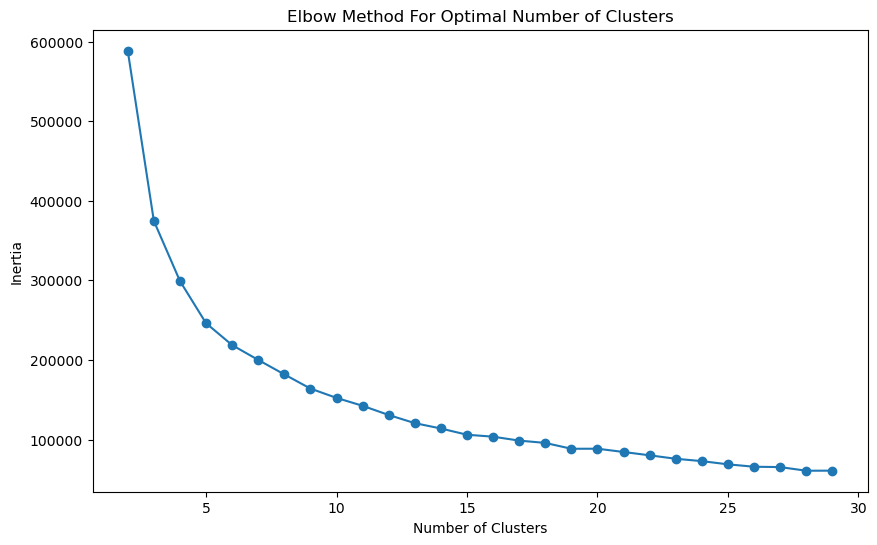

C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.




PCA Result DataFrame with Cluster Labels:
           PC1        PC2        PC3  Cluster Ligand
0    -1.902116   7.092992  -6.012850        2    NaN
1    10.066094   4.047400   5.607776        2    002
2    16.635596  -2.951180  -5.856208        0    003
3     9.654269 -28.880338 -58.276534        0    004
4   -10.935274 -25.399104 -38.990090        0    005
..         ...        ...        ...      ...    ...
434  -4.813016 -39.929526  -7.440912        0    466
435  13.629687 -25.662575  -4.338549        0    467
436 -43.462092 -32.471188  -1.831955        3    468
437  11.628966 -27.159968  -6.431501        0    471
438 -29.296851 -31.822177   8.325075        3    472

[439 rows x 5 columns]


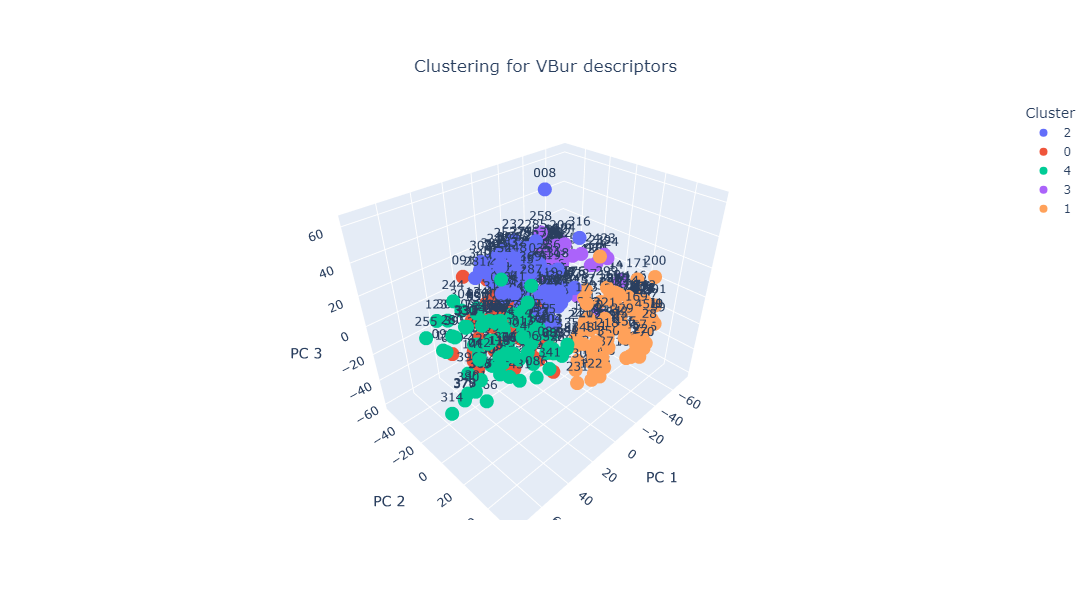

{'c1': ['003', '004', '005', '006', '007', '009', '013', '014', '015', '016', '027', '029', '033', '048', '053', '080', '081', '082', '091', '093', '095', '097', '100', '107', '120', '124', '131', '135', '137', '138', '139', '140', '142', '143', '144', '189', '192', '195', '233', '234', '242', '243', '245', '246', '249', '260', '261', '262', '267', '268', '271', '273', '277', '278', '286', '289', '290', '291', '292', '293', '324', '328', '368', '370', '390', '398', '406', '407', '408', '410', '422', '430', '441', '442', '444', '445', '446', '447', '448', '449', '457', '461', '466', '467', '471'], 'c2': ['038', '072', '073', '074', '075', '076', '077', '078', '092', '099', '111', '121', '122', '145', '146', '149', '150', '151', '160', '161', '168', '169', '170', '171', '172', '173', '174', '177', '178', '179', '180', '181', '182', '183', '186', '199', '200', '201', '202', '205', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222

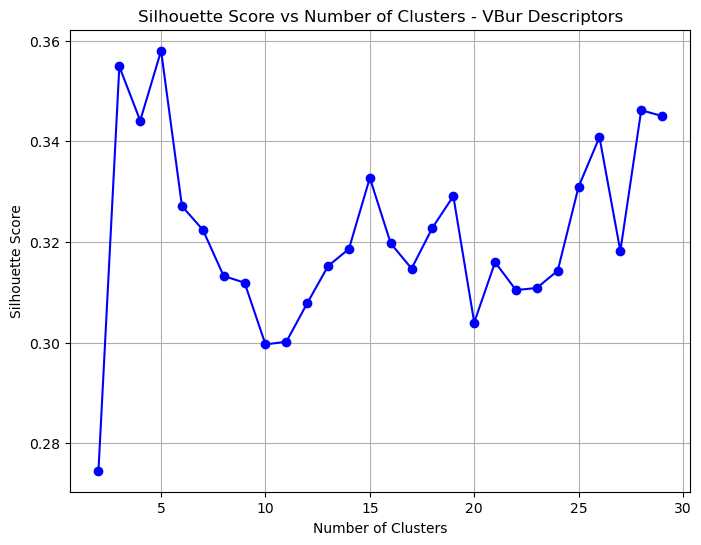

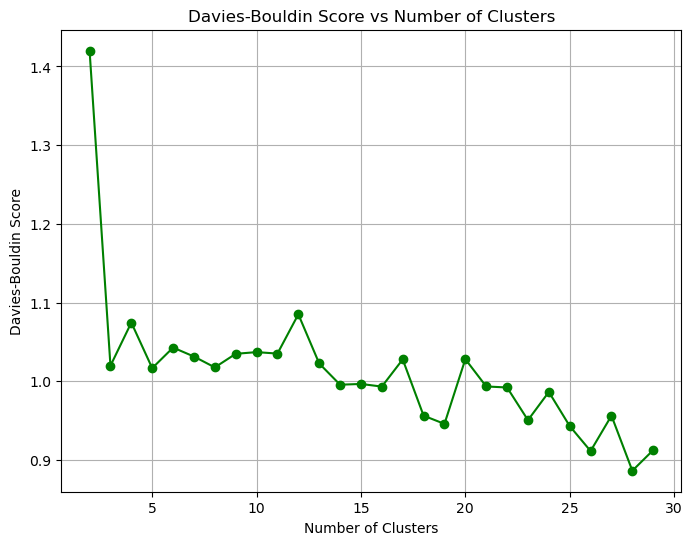

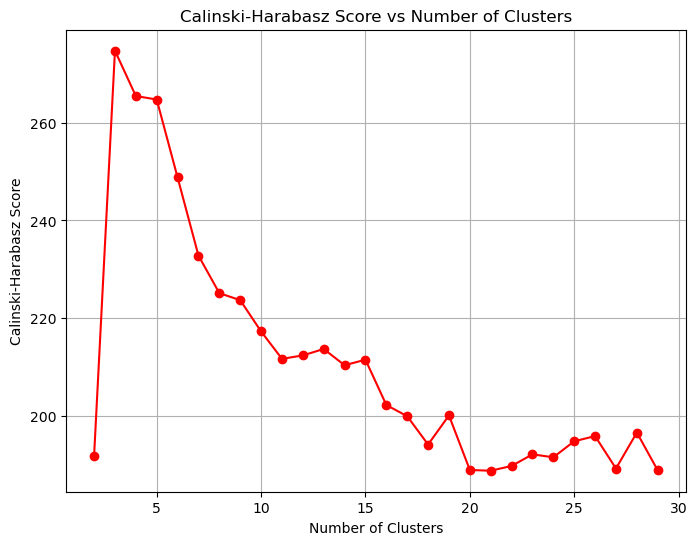

In [14]:
# Generate dataframe from pca data: 
pca_df = pd.DataFrame(data=components, columns=['PC1', 'PC2','PC3'])

# Apply KMeans Clustering
# Define a range of clusters to evaluate
range_n_clusters = list(range(2, 30))

# Initialize variables to store the best number of clusters and corresponding metrics
best_n_clusters_davies_bouldin = 0
best_n_clusters_silhouette = 0
best_n_clusters_calinski_harabasz = 0
best_silhouette_score = -1
best_davies_bouldin_score = float('inf')
best_calinski_harabasz_score = -1
best_adjusted_rand_score = -1
best_mutual_info_score = -1
inertia = []

# Initialize lists to store the metrics for each number of clusters
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

# Iterate over different cluster numbers to find the optimal number
for n_clusters in range_n_clusters:
    kmeans= KMeans(init="k-means++", n_clusters=n_clusters, n_init=4, random_state=42)
    cluster_labels = kmeans.fit_predict(pca_df)
    
    # Calculate clustering metcis
    silhouette_avg = silhouette_score(pca_df, cluster_labels)
    db_score = davies_bouldin_score(pca_df, cluster_labels)
    ch_score = calinski_harabasz_score(pca_df, cluster_labels)
    inertia.append(kmeans.inertia_)
    
    # Append metrics to corresponding lists
    silhouette_scores.append(silhouette_avg)
    davies_bouldin_scores.append(db_score)
    calinski_harabasz_scores.append(ch_score)
    
    # Print the scores for the current number of clusters
    # print(f"For n_clusters = {n_clusters}:")
    # print(f" - Silhouette score: {silhouette_avg}")
    # print(f" - Davies-Bouldin score: {db_score}")
    # print(f" - Calinski-Harabasz score: {ch_score}")
    
    # Update the best silhouette score and corresponding number of clusters
    if silhouette_avg > best_silhouette_score:
        best_n_clusters_silhouette = n_clusters
        best_silhouette_score = silhouette_avg

    if db_score < best_davies_bouldin_score:               # Lower Davies-Bouldin score == better
        best_n_clusters_davies_bouldin = n_clusters
        best_davies_bouldin_score = db_score

    if ch_score > best_calinski_harabasz_score:
        best_n_clusters_calinski_harabasz = n_clusters
        best_calinski_harabasz_score = ch_score

# Print the optimal number of clusters and the best silhouette score
print(f" - Best Silhouette score: {best_silhouette_score}, No. of clusters: {best_n_clusters_silhouette}")
print(f" - Best Davies-Bouldin score: {best_davies_bouldin_score}, No. of clusters: {best_n_clusters_davies_bouldin}")
print(f" - Best Calinski-Harabasz score: {best_calinski_harabasz_score}, No. of clusters: {best_n_clusters_calinski_harabasz}")

# Plot the inertia to visualize the elbow method
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Apply KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=best_n_clusters_silhouette, random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)

# Add cluster labels to the PCA result DataFrame
pca_df['Cluster'] = cluster_labels
pca_df['Ligand'] = X['ligand_id']


# Print the PCA result DataFrame with cluster labels
print("\nPCA Result DataFrame with Cluster Labels:")
print(pca_df)


# Create a dictionary to store clusters and their corresponding ligands
cluster_dict_vbur_descriptor = {}
for cluster_num in range(best_n_clusters_silhouette):                                             
    cluster_key = f'c{cluster_num + 1}'  # Create cluster key like 'c1', 'c2', etc.
    ligands_in_cluster = pca_df[pca_df['Cluster'] == cluster_num]['Ligand'].tolist()
    cluster_dict_vbur_descriptor[cluster_key] = ligands_in_cluster

# Visualize PCA with the best number of clusters
# Perform PCA to reduce to 3 dimensions for visualization
pca = PCA(n_components=3)
components = pca.fit_transform(X_vbur)

# Calculate the total variance explained by the first 3 components
total_var = pca.explained_variance_ratio_.sum() * 100

# Create a 3D scatter plot using Plotly, coloring points by cluster labels
fig = px.scatter_3d(
    components,
    x=0,
    y=1,
    z=2,
    color=pca_df['Cluster'].astype(str),  # Convert cluster labels to string for color differentiation
    text=pca_df['Ligand'],
    title=f'Clustering for VBur descriptors',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3', 'color': 'Cluster'}
)

# Update layout for the 3D scatter plot
fig.update_layout(
    width=800, 
    height=600,
    coloraxis_colorbar=dict(
        title=dict(text="Cluster",
                   side="top"),
        x=0.85,  # Position the legend closer to the scatter plot
        y=0.5,
        xanchor='left',
        yanchor='middle'
    ),
    title=dict(
        x=0.5,          # Horizontal position (centered)
        y=0.9,          # Vertical position (closer to the plot)
        xanchor='center',
        yanchor='top'
    )
)

# Show the plot
fig.show()

# Save the figure as PNG
fig.write_image("pca_3d_plot_vbur_cluster.png")

# Save the figure as HTML
fig.write_html("pca_3d_plot_vbur_cluster.html")


# Print the dictionary
print(cluster_dict_vbur_descriptor)

# Plot Silhouette Score
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, silhouette_scores, label='Silhouette Score', marker='o', color='blue')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters - VBur Descriptors')
plt.grid(True)
# Save the figure
plt.savefig("silhouette_score_plot_vbur.png", format='png')
plt.show()


# Plot Davies-Bouldin Score
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, davies_bouldin_scores, label='Davies-Bouldin Score', marker='o', color='green')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Score vs Number of Clusters')
plt.grid(True)
plt.show()

# Plot Calinski-Harabasz Score
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, calinski_harabasz_scores, label='Calinski-Harabasz Score', marker='o', color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Score')
plt.title('Calinski-Harabasz Score vs Number of Clusters')
plt.grid(True)
plt.show()



### Generate PCA map with NBO descriptors - find out cluster combinations through this

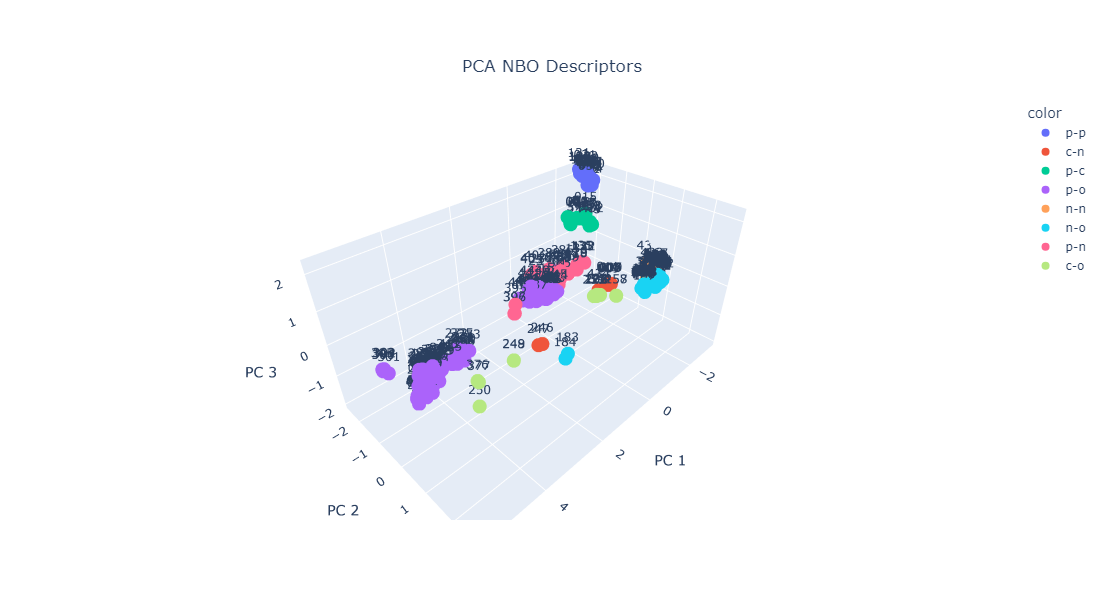

In [15]:
A_B_NBO_values = X_nbo['A-B_NBO'].tolist()
float_values = [float(value) for value in A_B_NBO_values]

A_NBO_values = X_nbo['A_NBO'].tolist()
float_values = [float(value) for value in A_NBO_values]


NBO_dist_2_a_b_diff = X_nbo['NBO-dist-2-a-b-diff'].tolist()
NBO_dist_2_a_b_diff = [float(value) for value in NBO_dist_2_a_b_diff]

NBO_dist_3_2_b_avg_diff = X_nbo['NBO-dist-3-2-b-avg-diff'].tolist()
NBO_dist_3_2_b_avg_diff = [float(value) for value in NBO_dist_2_a_b_diff]

vbur_octant_2 = X_2['% VBur octant 2'].tolist()
vbur_octant_2 = [float(value) for value in vbur_octant_2]


#Create PCA Plot in 3D
pca = PCA(n_components=3)
components = pca.fit_transform(X_nbo)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components,
    x=0,
    y=1,
    z=2,
    text=ligand_id,
    color = donor_atom_comb,
    title=f'PCA NBO Descriptors',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)

fig.update_layout(width=800, 
                  height=600,
                  coloraxis_colorbar=dict(
                  title=dict(text="Percent Buried<br>Volume",
                             side="top"),
                  x=0.85,  # Position the legend closer to the scatter plot
                  y=0.5,
                  xanchor='left',
                  yanchor='middle'),
                  title=dict(
                  x=0.5,          # Horizontal position (centered)
                  y=0.9,          # Vertical position (closer to the plot)
                  xanchor='center',
                  yanchor='top'
                    ) 
                 )
fig.show()

# Save the figure as PNG
fig.write_image("pca_3d_plot_nbo.png")

# Save the figure as HTML
fig.write_html("pca_3d_plot_nbo.html")

C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with M

 - Best Silhouette score: 0.7269280065283437, No. of clusters: 4
 - Best Davies-Bouldin score: 0.4230822689721713, No. of clusters: 4
 - Best Calinski-Harabasz score: 4369.7269341549045, No. of clusters: 29


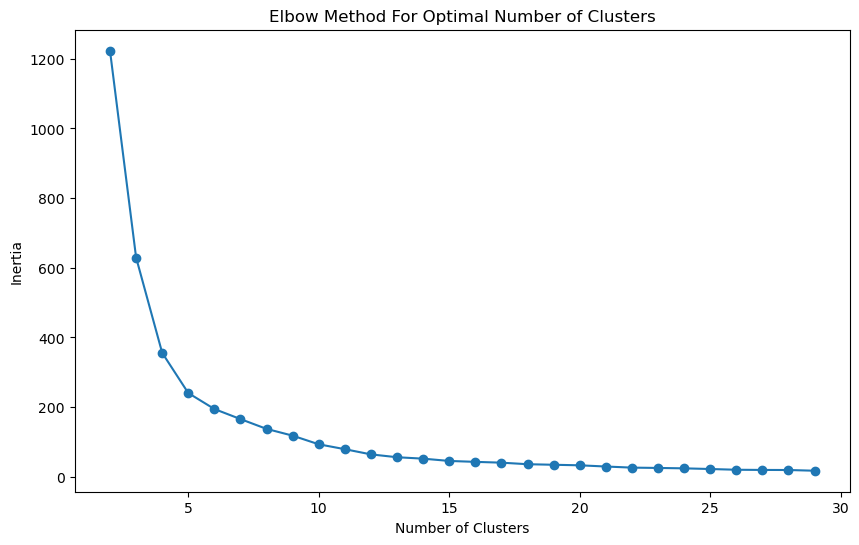

C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.




PCA Result DataFrame with Cluster Labels:
          PC1       PC2       PC3  Cluster Ligand
0   -2.738573 -1.907825  1.941712        3    NaN
1   -2.740730 -1.875021  1.926009        3    002
2   -2.742705 -1.854354  1.875505        3    003
3   -2.008573 -0.263697 -0.709211        2    004
4   -1.991918 -0.273961 -0.720836        2    005
..        ...       ...       ...      ...    ...
434  4.559341 -1.328734 -2.010467        1    466
435 -0.390511 -1.310977 -0.867704        0    467
436 -0.382610 -1.473707 -0.726979        0    468
437 -0.330239 -1.355830 -0.866509        0    471
438  5.277080  0.447262  0.581708        1    472

[439 rows x 5 columns]


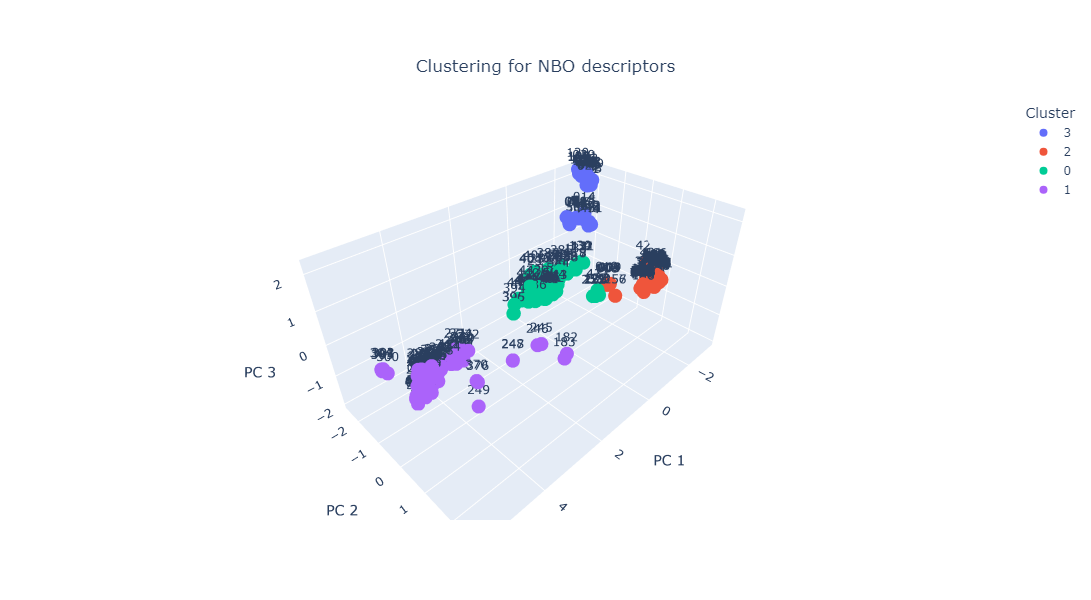

{'c1': ['036', '079', '080', '081', '082', '083', '093', '094', '101', '102', '103', '104', '105', '106', '107', '117', '118', '119', '121', '122', '123', '130', '131', '132', '133', '134', '135', '143', '144', '152', '153', '154', '155', '156', '157', '158', '159', '187', '188', '189', '190', '191', '192', '193', '194', '232', '233', '234', '235', '236', '258', '259', '329', '353', '382', '383', '384', '385', '386', '387', '388', '389', '390', '394', '395', '396', '403', '404', '405', '433', '438', '439', '440', '441', '442', '443', '444', '445', '446', '447', '448', '449', '467', '468', '471'], 'c2': ['037', '038', '039', '084', '085', '086', '087', '088', '089', '090', '091', '092', '095', '096', '097', '098', '099', '100', '108', '109', '110', '111', '136', '137', '138', '182', '183', '184', '186', '242', '243', '244', '245', '246', '247', '248', '249', '250', '251', '252', '253', '254', '255', '260', '261', '262', '263', '266', '267', '268', '269', '270', '271', '272', '273', '274

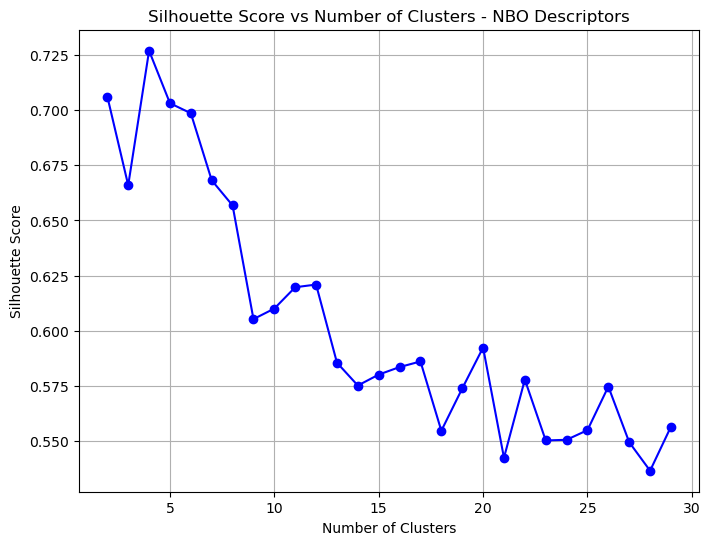

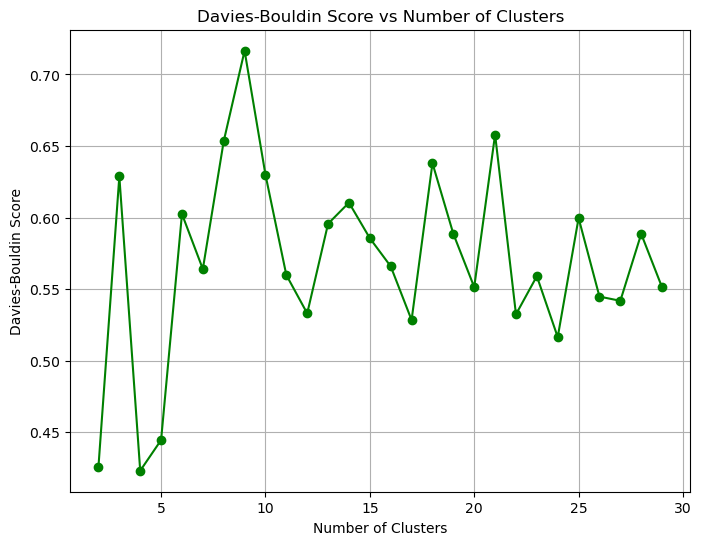

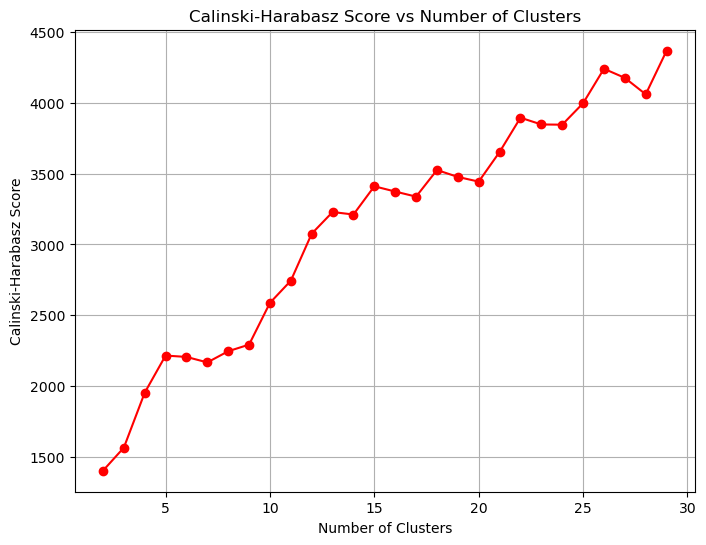

In [16]:
# Generate dataframe from pca data: 
pca_df = pd.DataFrame(data=components, columns=['PC1', 'PC2','PC3'])

# Apply KMeans Clustering
# Define a range of clusters to evaluate
range_n_clusters = list(range(2, 30))

# Initialize variables to store the best number of clusters and corresponding metrics
best_n_clusters_davies_bouldin = 0
best_n_clusters_silhouette = 0
best_n_clusters_calinski_harabasz = 0
best_silhouette_score = -1
best_davies_bouldin_score = float('inf')
best_calinski_harabasz_score = -1
best_adjusted_rand_score = -1
best_mutual_info_score = -1
inertia = []

# Initialize lists to store the metrics for each number of clusters
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

# Iterate over different cluster numbers to find the optimal number
for n_clusters in range_n_clusters:
    kmeans= KMeans(init="k-means++", n_clusters=n_clusters, n_init=4, random_state=42)
    cluster_labels = kmeans.fit_predict(pca_df)
    
    # Calculate clustering metcis
    silhouette_avg = silhouette_score(pca_df, cluster_labels)
    db_score = davies_bouldin_score(pca_df, cluster_labels)
    ch_score = calinski_harabasz_score(pca_df, cluster_labels)
    inertia.append(kmeans.inertia_)
    
    # Append metrics to corresponding lists
    silhouette_scores.append(silhouette_avg)
    davies_bouldin_scores.append(db_score)
    calinski_harabasz_scores.append(ch_score)
    
    # Print the scores for the current number of clusters
    # print(f"For n_clusters = {n_clusters}:")
    # print(f" - Silhouette score: {silhouette_avg}")
    # print(f" - Davies-Bouldin score: {db_score}")
    # print(f" - Calinski-Harabasz score: {ch_score}")
    
    # Update the best silhouette score and corresponding number of clusters
    if silhouette_avg > best_silhouette_score:            # Maximize silhouette score
        best_n_clusters_silhouette = n_clusters
        best_silhouette_score = silhouette_avg

    if db_score < best_davies_bouldin_score:               # Lower Davies-Bouldin score == better
        best_n_clusters_davies_bouldin = n_clusters
        best_davies_bouldin_score = db_score

    if ch_score > best_calinski_harabasz_score:           # Maximize calinski harabasz score
        best_n_clusters_calinski_harabasz = n_clusters
        best_calinski_harabasz_score = ch_score

# Print the optimal number of clusters and the best silhouette score
print(f" - Best Silhouette score: {best_silhouette_score}, No. of clusters: {best_n_clusters_silhouette}")
print(f" - Best Davies-Bouldin score: {best_davies_bouldin_score}, No. of clusters: {best_n_clusters_davies_bouldin}")
print(f" - Best Calinski-Harabasz score: {best_calinski_harabasz_score}, No. of clusters: {best_n_clusters_calinski_harabasz}")

# Plot the inertia to visualize the elbow method
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Apply KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=best_n_clusters_silhouette, random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)

# Add cluster labels to the PCA result DataFrame
pca_df['Cluster'] = cluster_labels
pca_df['Ligand'] = X['ligand_id']


# Print the PCA result DataFrame with cluster labels
print("\nPCA Result DataFrame with Cluster Labels:")
print(pca_df)


# Create a dictionary to store clusters and their corresponding ligands
cluster_dict_nbo_descriptor = {}
for cluster_num in range(best_n_clusters_silhouette):                                             
    cluster_key = f'c{cluster_num + 1}'  # Create cluster key like 'c1', 'c2', etc.
    ligands_in_cluster = pca_df[pca_df['Cluster'] == cluster_num]['Ligand'].tolist()
    cluster_dict_nbo_descriptor[cluster_key] = ligands_in_cluster

# Visualize PCA with the best number of clusters
# Perform PCA to reduce to 3 dimensions for visualization
pca = PCA(n_components=3)
components = pca.fit_transform(X_nbo)

# Calculate the total variance explained by the first 3 components
total_var = pca.explained_variance_ratio_.sum() * 100

# Create a 3D scatter plot using Plotly, coloring points by cluster labels
fig = px.scatter_3d(
    components,
    x=0,
    y=1,
    z=2,
    color=pca_df['Cluster'].astype(str),  # Convert cluster labels to string for color differentiation
    text=pca_df['Ligand'],
    title=f'Clustering for NBO descriptors',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3', 'color': 'Cluster'}
)

# Update layout for the 3D scatter plot
fig.update_layout(
    width=800, 
    height=600,
    coloraxis_colorbar=dict(
        title=dict(text="Cluster",
                   side="top"),
        x=0.85,  # Position the legend closer to the scatter plot
        y=0.5,
        xanchor='left',
        yanchor='middle'
    ),
    title=dict(
        x=0.5,          # Horizontal position (centered)
        y=0.9,          # Vertical position (closer to the plot)
        xanchor='center',
        yanchor='top'
    )
)

# Show the plot
fig.show()

# Save the figure as PNG
fig.write_image("pca_3d_plot_nbo_cluster.png")

# Save the figure as HTML
fig.write_html("pca_3d_plot_nbo_cluster.html")


# Print the dictionary
print(cluster_dict_nbo_descriptor)

# Plot Silhouette Score
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, silhouette_scores, label='Silhouette Score', marker='o', color='blue')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters - NBO Descriptors')
plt.grid(True)
# Save the figure
plt.savefig("silhouette_score_plot_nbo.png", format='png')
plt.show()

# Plot Davies-Bouldin Score
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, davies_bouldin_scores, label='Davies-Bouldin Score', marker='o', color='green')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Score vs Number of Clusters')
plt.grid(True)
plt.show()

# Plot Calinski-Harabasz Score
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, calinski_harabasz_scores, label='Calinski-Harabasz Score', marker='o', color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Score')
plt.title('Calinski-Harabasz Score vs Number of Clusters')
plt.grid(True)
plt.show()



## Store clusters of ligand ids in a .txt file

In [17]:
import json 

data = {
    'cluster_dict_all_descriptor' : cluster_dict_all_descriptor,
    'cluster_dict_nbo_descriptor' : cluster_dict_nbo_descriptor,
    'cluster_dict_vbur_descriptor' : cluster_dict_vbur_descriptor
    }

# Convert the combined dictionary to a JSON string
json_data = json.dumps(data)

# Write the JSON string to a .txt file
with open('cluster_dictionaries.txt', 'w') as file:
    file.write(json_data)

In [18]:
cluster_dict_all_descriptor

{'c1': ['004',
  '005',
  '006',
  '007',
  '009',
  '013',
  '014',
  '015',
  '016',
  '027',
  '029',
  '033',
  '048',
  '053',
  '080',
  '081',
  '082',
  '091',
  '093',
  '095',
  '097',
  '100',
  '107',
  '120',
  '124',
  '131',
  '135',
  '137',
  '138',
  '139',
  '140',
  '142',
  '143',
  '144',
  '189',
  '192',
  '195',
  '233',
  '234',
  '242',
  '243',
  '245',
  '246',
  '249',
  '260',
  '261',
  '262',
  '267',
  '268',
  '271',
  '273',
  '277',
  '278',
  '286',
  '289',
  '290',
  '291',
  '292',
  '293',
  '324',
  '328',
  '368',
  '370',
  '390',
  '398',
  '406',
  '407',
  '408',
  '410',
  '422',
  '430',
  '441',
  '442',
  '444',
  '445',
  '446',
  '447',
  '448',
  '449',
  '461',
  '466',
  '467',
  '471'],
 'c2': ['038',
  '072',
  '073',
  '074',
  '075',
  '076',
  '077',
  '078',
  '092',
  '099',
  '111',
  '121',
  '122',
  '145',
  '146',
  '149',
  '150',
  '151',
  '160',
  '161',
  '168',
  '169',
  '170',
  '171',
  '172',
  '173',
  '174

In [19]:
cluster_dict_nbo_descriptor

{'c1': ['036',
  '079',
  '080',
  '081',
  '082',
  '083',
  '093',
  '094',
  '101',
  '102',
  '103',
  '104',
  '105',
  '106',
  '107',
  '117',
  '118',
  '119',
  '121',
  '122',
  '123',
  '130',
  '131',
  '132',
  '133',
  '134',
  '135',
  '143',
  '144',
  '152',
  '153',
  '154',
  '155',
  '156',
  '157',
  '158',
  '159',
  '187',
  '188',
  '189',
  '190',
  '191',
  '192',
  '193',
  '194',
  '232',
  '233',
  '234',
  '235',
  '236',
  '258',
  '259',
  '329',
  '353',
  '382',
  '383',
  '384',
  '385',
  '386',
  '387',
  '388',
  '389',
  '390',
  '394',
  '395',
  '396',
  '403',
  '404',
  '405',
  '433',
  '438',
  '439',
  '440',
  '441',
  '442',
  '443',
  '444',
  '445',
  '446',
  '447',
  '448',
  '449',
  '467',
  '468',
  '471'],
 'c2': ['037',
  '038',
  '039',
  '084',
  '085',
  '086',
  '087',
  '088',
  '089',
  '090',
  '091',
  '092',
  '095',
  '096',
  '097',
  '098',
  '099',
  '100',
  '108',
  '109',
  '110',
  '111',
  '136',
  '137',
  '138

In [20]:
cluster_dict_vbur_descriptor

{'c1': ['003',
  '004',
  '005',
  '006',
  '007',
  '009',
  '013',
  '014',
  '015',
  '016',
  '027',
  '029',
  '033',
  '048',
  '053',
  '080',
  '081',
  '082',
  '091',
  '093',
  '095',
  '097',
  '100',
  '107',
  '120',
  '124',
  '131',
  '135',
  '137',
  '138',
  '139',
  '140',
  '142',
  '143',
  '144',
  '189',
  '192',
  '195',
  '233',
  '234',
  '242',
  '243',
  '245',
  '246',
  '249',
  '260',
  '261',
  '262',
  '267',
  '268',
  '271',
  '273',
  '277',
  '278',
  '286',
  '289',
  '290',
  '291',
  '292',
  '293',
  '324',
  '328',
  '368',
  '370',
  '390',
  '398',
  '406',
  '407',
  '408',
  '410',
  '422',
  '430',
  '441',
  '442',
  '444',
  '445',
  '446',
  '447',
  '448',
  '449',
  '457',
  '461',
  '466',
  '467',
  '471'],
 'c2': ['038',
  '072',
  '073',
  '074',
  '075',
  '076',
  '077',
  '078',
  '092',
  '099',
  '111',
  '121',
  '122',
  '145',
  '146',
  '149',
  '150',
  '151',
  '160',
  '161',
  '168',
  '169',
  '170',
  '171',
  '172

In [21]:
# Function to find the cluster name by number
def find_cluster(number, cluster_dict):
    for cluster_name, numbers in cluster_dict.items():
        if number in numbers:
            return cluster_name
    return "Number not found in any cluster"

# Example usage
number = '241'
cluster_name = find_cluster(number, cluster_dict_all_descriptor)
print(f'The number {number} belongs to cluster: {cluster_name}')

The number 241 belongs to cluster: c2
